In [1]:
using Logging
Logging.disable_logging(LogLevel(3))

using LinearAlgebra
using SparseArrays
using KrylovKit
using Plots
using Colors
using IterTools
Threads.nthreads()


(process:13308): GLib-GIO-WARNING **: 16:59:53.825: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_19.0.3.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


4

In [63]:
function assembly(T,J,N,N²)
    Λ = spzeros(N²,N²);
    @views for i in 1:N
        Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs extradiag supérieurs
        Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inférieurs
    end
    return Λ
end

function hamiltonian_2D(δr, δr², δR, δR², N, N², V, m, M, ħ)
    # BLOC EXTRA-DIAGONAL 
    J = -ħ^2*  1/(2*M*δR²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*δr²)+1/(M*δR²))*ones(Float64,N);  # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*δr²)*ones(Float64,N-1);     # vecteur de la sur- et sous-diagonale remplies de 1
    T = -ħ^2*  SymTridiagonal(diag, extra_diag);    # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = assembly(T,J,N,N²)
    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ+V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end


function hamiltonian_1D(Δd², N, V, m, ħ)
    Λ = -ħ^2*1/(Δd²*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
    V = sparse(Diagonal(V)); # V_fun.(LinRange(r_min,r_max,N)) pour créer l'argument
    H = Λ + V; 
    H, Λ, V
end


function hamiltonian_2D_rescaled(δr, δr², N, N², Vu, m, ϵ, K, ħ)
    # BLOC EXTRA-DIAGONAL 
    J = -ħ^2/2 * K*ϵ^2*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*δr²)+2*K*ϵ^2)*ones(Float64,N);      # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*δr²)*ones(Float64,N-1);     # vecteur de la sur- et sous-diagonale remplies de 1
    T = -ħ^2*  SymTridiagonal(diag, extra_diag);    # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = assembly(T,J,N,N²);
    V = Diagonal(reshape(Vu,N²)); # a priori inutile de convertir en sparse avant

    H = Λ+V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end

hamiltonian_2D_rescaled (generic function with 1 method)

In [64]:
# DÉRIVÉES PREMIÈRES
# ∂ première à l'ordre 2
diff1_ctr_o2  = [-1/2 0. 1/2];

# ∂ première à l'ordre 4
diff1_fwd_o4  = [−25/12 4. −3. 4/3 −1/4];
diff1_bwd_o4  = [1/4 -4/3 3. -4 25/12];
diff1_ctr_o4 = [+1/12, −2/3,  0.,  2/3, −1/12];

# ∂ première à l'ordre 6
diff1_ctr_o6  = [−1/60 3/20 −3/4 0. 3/4 −3/20 1/60];
diff1_fwd_o6  = [−49/20 6. −15/2 20/3 −15/4 6/5 −1/6];
diff1_bwd_o6 = [1/6 -6/5 15/4 -20/3 15/2 -6. 49/20];


# ∂ première à l'ordre 8
diff1_ctr_o8 =  [1/280 −4/105 1/5 −4/5 0. 4/5 −1/5 4/105 −1/280];
diff1_fwd_o8  = [-760/280 8. -14. 56/3 -35/2 56/5 -14/3 8/7 -1/8];
diff1_bwd_o8  = [1/8 -8/7 14/3 -56/5 35/2 -56/3 14. -8. 760/280];


# DÉRIVÉES SECONDES
# ∂ seconde à l'ordre 6
diff2_ctr_o6 = [1/90 -3/20 3/2 -49/18 3/2 -3/20 1/90];
diff2_fwd_o6 = [469/90 -223/10 879/20 -949/18 41. -201/10 1019/180 -7/10];
diff2_bwd_o6 = [-7/10 1019/180 -201/10 41. -949/18 879/20 -223/10 469/90];


# ∂ seconde à l'ordre 8
diff2_ctr_o8 = [−1/560 8/315 −1/5 8/5 −205/72 8/5 −1/5 8/315 −1/560];

On part d'un hamiltonien représentant par exemple, l'énergie de la molécule H_2^+.
\begin{equation}
 -\frac{1}{2m} \frac{\partial^2}{\partial r^2} - \frac{1}{2M} \frac{\partial^2}{\partial R^2} + V(r,R)
\end{equation}
Qu'on décompose en trois termes
\begin{equation}
H = \hat{H}_x + \hat{H}_y + \hat{W}
\end{equation}

avec

\begin{equation}
\hat{H}^0_R =  - \frac{1}{2m} \frac{\partial^2}{\partial R^2} + \frac{1}{2} \frac{\mathrm{d}^2 E_0}{\mathrm{d}R^2}(R_0)(R-R_0)^2 
\end{equation}

\begin{equation}
        \hat{H}^0_r = - \frac{1}{2M} \frac{\partial^2}{\partial x^2} + V(r,R_0)   
\end{equation}

et la perturbation
\begin{equation}
\hat{W} = \frac{\partial V}{\partial R}(r,R_0)(R-R_0)  + \frac{1}{2} \left(\frac{\partial^2V}{\partial R^2}(r,R_0) -\frac{\mathrm{d}^2 E_0}{\mathrm{d}R^2}(R_0) \right)   (R-R_0)^2 + \text{h.o.t.}
\end{equation}
sur laquelle on néglige les termes de plus haut ordres (dans l'écriture ci-dessus, on a négligé les termes d'ordre supérieur ou égal à 3)


In [93]:
# Dans la fonction suivante toutes les variables avec chapeau désignent des opérateurs 2D (matrices N² × N²)
# Les Λ (sans chapeau) sont aussi des opérateurs (ce sont les laplaciens)
function decompose_hamiltonian(r_min, r_max, R_min, R_max, N, V_nucl_el, V_nucl_nucl, m, M, ħ, kdim)
    δr = (r_max-r_min)/(N-1);
    δR = (R_max-R_min)/(N-1);
    δr² = δr*δr;
    δR² = δR*δR;
    N² = N*N;

    # CONSTRUCTION DE LA MESHGRID
    rs = Vector(r_min:δr:r_max); # direction coordonnée électron
    Rs = Vector(R_min:δR:R_max); # direction coordonnée distance noyau-noyau
    X = ones(N)' .* rs;
    Y = Rs' .* ones(N);
    V = zeros(N,N);

    # CONSTRUCTION DU POTENTIEL ET DU HAMILTONIEN
    @. V = V_nucl_el(X, Y) + V_nucl_nucl(Y); # potentiel d'interaction sur la grille tous phénomènes compris
    Ĥ, Λ, V̂ = hamiltonian_2D(δr, δr², δR, δR², N, N², V, m, M, ħ);
    lowest_energies_y = zeros(N);

    LS = SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1)); # structure du laplacien adimensionné générique 1D

    # LAPLACIENS SUR AXES
    Λr = -ħ^2*1/(δr²*2*m)*LS;  # laplacien sur l'axe x
    ΛR = -ħ^2*1/(δR²*2*M)*LS;  # laplacien sur l'axe y


    # RECHERCHE DU R₀  minimisant l'énergie de l'état fondamental
    lE₀ = zeros(N);
    Base.Threads.@threads for j in 1:N
        Vx = sparse(Diagonal(Vector(V_nucl_el.(rs,R_min+j*δR)))) # potentiel en x à y=jδR fixé (i.e. à distance noyau-noyau fixé)
        vals, ~, infos = KrylovKit.eigsolve(Λr+Vx, N, 1, :SR, krylovdim=kdim);
        @assert infos.converged > 0;
        lE₀[j]     = infos.converged>=1 ? vals[1] + V_nucl_nucl(R_min + j*δR)  : NaN;
        # on récupère l'énergie  propre du niveau fondamental sur la tranche à y fixé
    end  

    # CALCUL DU R₀ ET DES RAIDEURS
    E₀_at_R₀, ind_R₀ = findmin(lE₀);
    R₀               = ind_R₀*δR + R_min;
    ∂²RR_of_E₀_at_R₀ = 1/(δR)^2 * dot(diff2_ctr_o8, view(lE₀, ind_R₀-4:ind_R₀+4));  # on calcule la dérivée seconde  à l'ordre 8 par rapport à y de E₀ en R₀
    K = ∂²RR_of_E₀_at_R₀; # second nom pour le paramétrage en u
    # constante de raideur sur l'axe (Oy) pour le hamiltonien non perturbé
    # ∂²RR_of_E₀_at_R₀ = K; constante de raideur pour la coordonnée nucléaire
    ϵ = 1/sqrt(sqrt(∂²RR_of_E₀_at_R₀*M));
    u₀ = 0;

    # RESCALING
    # chgt variable X = X₀ + ϵu
    # --> u ∈ [1/ϵ*(R_min-X₀), 1/ϵ*(R_max-X₀)]
    # donc notre nouvelle variable à partir d'ici devient u
    # V(R) = V(R₀+ϵu) = Ṽ(u)
    # Ψ(X) = Ψ~(u)   

    # NOUVEAUX PARAMETRES SUR AXE avec rescaling
    Λu = -ħ^2*K*ϵ^2*LS;
    u_min = 1/ϵ*(R_min-R₀);
    u_max = 1/ϵ*(R_max-R₀);
    δu = (u_max-u_min)/(N-1);
    us = Vector(u_min:δu:u_max);
    Yu = us' .* ones(N); # équivalent de Y




    # FONCTIONS POTENTIELS NON PERTURBÉS SUR AXES SÉPARÉS  
    V₀r  = @views V[:,ind_R₀];
    V₀R  = @views .5*∂²RR_of_E₀_at_R₀*(Rs.-R₀).^2;
    # en appliquant sparse ∘ Diagonal
    V₀u  = @views .5*K*ϵ^2*us.^2;
    # les potentiels opérateurs correpondants sur chaque axe s'obtiennent

    # OPÉRATEURS POTENTIELS NON PERTURBÉS SUR AXES SÉPARÉS 
    V̂⁰r  = sparse(Diagonal(V₀r));
    V̂⁰R  = sparse(Diagonal(V₀R));
    V̂⁰u  = sparse(Diagonal(V₀u)); 

    # HAMILTONIENS NON PERTURBÉS SUR AXES SÉPARÉS
    Ĥ⁰r  = Λr + V̂⁰r;
    Ĥ⁰R  = ΛR + V̂⁰R;
    Ĥ⁰u  = Λu + V̂⁰u;

    # FONCTION POTENTIEL NON PERTURBÉ SUR GRILLE
    V₀  = V[:,ind_R₀]*ones(N)'    + .5*∂²RR_of_E₀_at_R₀*(Y.-R₀).^2;
    V₀_res = V[:,ind_R₀]*ones(N)' + .5*K*ϵ^2*(us'.*ones(N)).^2; # PREMIER TERME À VÉRIFIER
    
    # OPÉRATEUR POTENTIEL NON PERTURBÉ SUR GRILLE
    V̂⁰  = Diagonal(reshape(V₀,  N²));
    V̂⁰_res = Diagonal(reshape(V₀_res, N²));
    
    

    Ĥ_res, Λ_res, V̂_res = hamiltonian_2D_rescaled(δr, δr², N, N², V₀_res, m, ϵ, K, ħ) # "res" pour rescaled

    
    Ĥ⁰     = Λ     + V̂⁰;   # avec paramétrage R
    Ĥ⁰_res = Λ_res + V̂⁰_res;  # avec paramétrage u

    
    # A COMPLETER AVEC LE PARAMETRAGE EN u !!!!!!!!!!!!!!!!!!!!!!!!!

    # FONCTION PERTURBATION Vp (développement de Taylor)
        # ordre 1 en espace
    ∂R_of_V_at_rR₀   = 1/δR*  V[:,ind_R₀-4:ind_R₀+4] * diff1_ctr_o8';               # vecteur contenant ∂V/∂R(r,R₀)   pour tous les x
    ∂u_of_V_at_ru₀   = ϵ*∂R_of_V_at_rR₀;
    V₁               = ∂R_of_V_at_rR₀*ones(N)' .* (Y.-R₀);                               # on le transforme en grille
    V₁_res           = ∂u_of_V_at_ru₀*ones(N)' .* Yu # validé après y avoir réfléchi
        # ordre 2 en espace
    ∂²RR_of_V_at_rR₀ = 1/δR²* V[:,ind_R₀-4:ind_R₀+4] * diff2_ctr_o8';               # vecteur contenant ∂²V/∂R²(r,R₀) pour tous les x
    ∂²uu_of_V_at_ru₀ = ϵ^2*∂²RR_of_V_at_rR₀;
    V₂               = .5*(∂²RR_of_V_at_rR₀*ones(N)' .- ∂²RR_of_E₀_at_R₀) .* (Y.-R₀).^2; # on le transforme en grille
    V₂_res           = .5*(∂²uu_of_V_at_ru₀*ones(N)' .- ϵ^2*K) .* us.^2;
    # perturbation totale ordre 1 + ordre 2
    Vp  = V₁ + V₂;
    Vp_res = V₁_res + V₂_res;
  
    # OPÉRATEUR PERTURBATION Ŵ
    Ŵ = Diagonal(reshape(Vp, N²));
    
    return Λ, Ĥ, V̂, V,
           Ĥ⁰, V̂⁰, V₀,
           Ĥ⁰r, Ĥ⁰R, V̂⁰r, V̂⁰R, V₀r, V₀R,
           Ŵ, Vp, V₁, V₂,
           lE₀, ind_R₀, R₀,
           δr, δR, rs, Rs,
           ∂²RR_of_E₀_at_R₀, ∂²RR_of_V_at_rR₀, ∂R_of_V_at_rR₀,
           Λu, u_min, u_max, δu, us, V₀_res, V̂⁰_res, Ĥ_res, Λ_res, V̂_res, Ĥ⁰_res, ϵ, Vp_res

end

decompose_hamiltonian (generic function with 1 method)

### 1) Création d'un problème avec un potentiel

In [136]:
# A = rand(2,2);
# A = Matrix{Float64}(I, 2,2);

# A = [0.7 0.4; 0.4 0.8];
# psd = 2*A'*A;
me = 1; mp = 10;
M=(2*mp^3+mp^2*me)/(2*mp*(me+mp));
m=(2*mp^2*me)/(mp*(2*mp+me)); 
r_min=-5.; r_max=5.; R_min=1.0; R_max=2.5; N=150; ω=1.; ħ=1.; kdim=30; # augmenter la dimension Krylov quand N est grand: pour N=200, prendre kdim=50
β=1.5; η=.5; V0=1.5; σ=1.;


function V_nucl_el(r,R)
     return -V0*( exp(-(r-R/2)^2/2/σ^2) + exp(-(r+R/2)^2/2/σ^2) ) # potentiels interaction électron avec les 2 noyaux
end

function V_nucl_nucl(R)
     return + β/sqrt(η^2+R^2) # potentiel interaction des 2 noyaux entre eux
end

V_nucl_nucl (generic function with 1 method)

### 2) Décomposition (approchée) d'un hamiltonien perturbé $H_0$ et d'une correction $\hat{W}$.
Remarque: lorsqu'on plot une heatmap d'une matrice avec l'axe des $x$ indicé $i$ et l'axe $y$ indicé $j$, on doit transposer car https://discourse.julialang.org/t/hi-evrybody-im-trying-to-overlay-a-scatter-plot-with-a-heatmap-using-plots-jl-bu/56067


$R₀$ minimise l'énergie de l'état fondamental du hamiltonien pris sur l'axe $y=R₀$ (la tranche)

  2.264561 seconds (1.24 M allocations: 183.881 MiB, 0.86% gc time, 5.96% compilation time)
ky=0.5432
R₀=1.6342
E₀(R₀)=-0.829
isposdef(Ĥ) = false


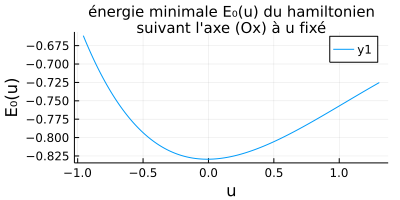

In [137]:
# 1 min pour 400 par 400, 20 sec pour 300 par 300
@time   Λ,                            # laplacien 2D commun
        Ĥ,   V̂,   V,                  # opérateurs et potentiel 2D originaux
        Ĥ⁰,  V̂⁰,  V₀,                 # hamiltonien et potentiel 2D non perturbés
        Ĥ⁰r, Ĥ⁰R, V̂⁰r, V̂⁰R, V₀r, V₀R, # opérateurs et potentiels 1D non perturbés
        Ŵ,   Vp,  V₁,  V₂,            # hamiltonien et potentiel de la perturbation et sa décomposition
        lE₀, ind_R₀, R₀,              # liste des énergies sur Ox en fonction de y et minimum R₀
        δr, δR, rs, Rs,               # paramètres du problème
        ∂²RR_of_E₀_at_R₀, ∂²RR_of_V_at_rR₀, ∂R_of_V_at_rR₀,
        Λu, u_min, u_max, δu, us, V₀_res, V̂⁰_res, Ĥ_res, Λ_res, V̂_res, Ĥ⁰_res, ϵ = decompose_hamiltonian(r_min, r_max, R_min, R_max, N, V_nucl_el, V_nucl_nucl, m, M, ħ, kdim);
        
        
println("ky=$(round(∂²RR_of_E₀_at_R₀,digits=4))\nR₀=$(round(R₀,digits=4))\nE₀(R₀)=$(round(lE₀[ind_R₀],digits=3))")
@show isposdef(Ĥ)
plot(us,lE₀, title="énergie minimale E₀(u) du hamiltonien\nsuivant l'axe (Ox) à u fixé", xlabel="u", ylabel="E₀(u)", size=(400,200), titlefontsize=10)

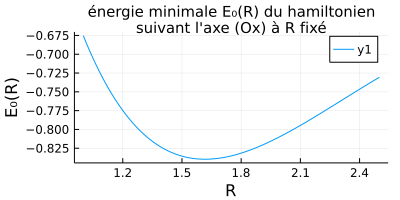

In [132]:
plot(Rs,lE₀, title="énergie minimale E₀(R) du hamiltonien\nsuivant l'axe (Ox) à R fixé", xlabel="R", ylabel="E₀(R)", size=(400,200), titlefontsize=10)

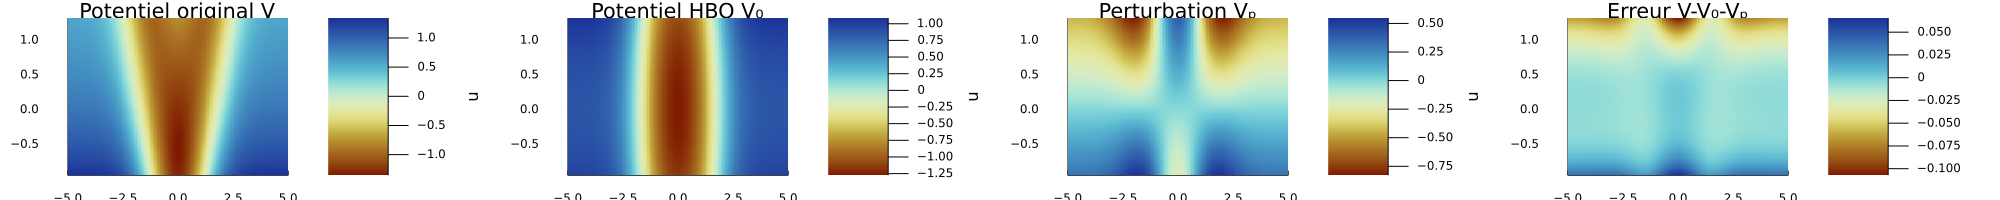

In [140]:
plot_V   = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), V', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Potentiel original V", grid=true, aspect_ratio=:auto ) 
plot_V₀  = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), V₀', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Potentiel HBO V₀", aspect_ratio=:auto )
plot_Vp  = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), Vp', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Perturbation Vₚ", aspect_ratio=:auto )
plot_dif = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N),(V-V₀-Vp)', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Erreur V-V₀-Vₚ", aspect_ratio=:auto ) # , clims=(-1000.,0.)
plot(plot_V, plot_V₀, plot_Vp, plot_dif, layout = (1, 4), legend = false, size=(2000,200))

### 3) Calcul 2D (triché) de l'état fondamental du hamiltonien original $Ĥ$

  1.549787 seconds (12.70 k allocations: 346.105 MiB, 1.16% gc time)
info.converged = 0


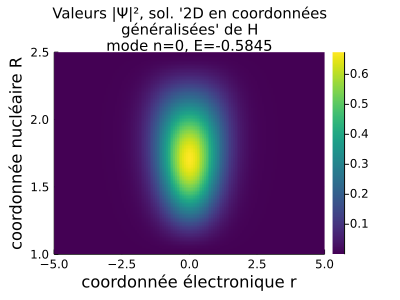

In [138]:
@time lE, lϕ, info = KrylovKit.eigsolve(Ĥ, N*N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 
densité = N^2/(R_max-R_min)/(r_max-r_min);
ϕH = lϕ[mode_numérique+1];
ϕH_p = densité*Matrix(transpose(reshape(ϕH.^2,N,N)));
heatmap(rs, Rs, ϕH_p,
    xlims = (r_min,r_max),
    ylims = (R_min,R_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    color=:viridis,
    right_margin = 7Plots.mm,
    up_margin = 3Plots.mm)

  1.731896 seconds (12.69 k allocations: 346.104 MiB, 0.84% gc time)
info.converged = 0


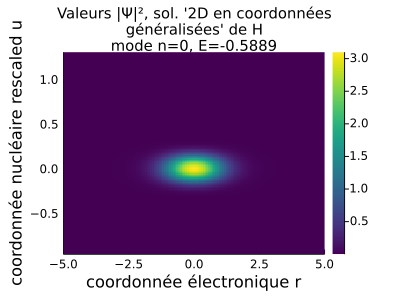

In [139]:
@time lE, lϕ, info = KrylovKit.eigsolve(Ĥ_res, N*N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 
densité = N^2/(R_max-R_min)/(r_max-r_min);
ϕH = lϕ[mode_numérique+1];
ϕH_p = densité*Matrix(transpose(reshape(ϕH.^2,N,N)));
heatmap(rs, us, ϕH_p,
    xlims = (r_min,r_max),
    ylims = (u_min,u_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire rescaled u",
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    color=:viridis,
    right_margin = 7Plots.mm,
    up_margin = 3Plots.mm)

### 3) Calcul 2D (triché) de l'état fondamental du hamiltonien perturbé $Ĥ⁰+ \lambda Ŵ (\neq Ĥ)$

  1.984605 seconds (12.70 k allocations: 349.014 MiB, 12.01% gc time)
info.converged = 0


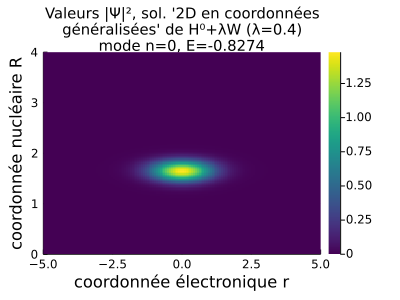

In [41]:
λ = .4;
@time lE, lϕ, info = KrylovKit.eigsolve(Ĥ⁰+λ*Ŵ, N*N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 
densité = N^2/(R_max-R_min)/(r_max-r_min);
ϕHλW = lϕ[mode_numérique+1];
ϕHλW_p = densité*Matrix(transpose(reshape(ϕHλW.^2,N,N)));
ϕHλW_p[abs.(ϕHλW_p) .< 1e-15] .= 0.;
heatmap(rs, Rs, ϕHλW_p,
    xlims = (r_min,r_max),
    ylims = (R_min,R_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    color=:viridis,
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H⁰+λW (λ=$λ)\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    right_margin = 8Plots.mm,
    up_margin = 3Plots.mm)

### 4) Calcul Axe $(Ox)$ des plus petits éléments propres (états + énergies) du hamiltonien électronique  $H_r$
On utilise une méthode itérative (Krylov), on ne calcule que les les plus petites énergies

  0.000521 seconds (533 allocations: 126.672 KiB)
infos.converged = 5


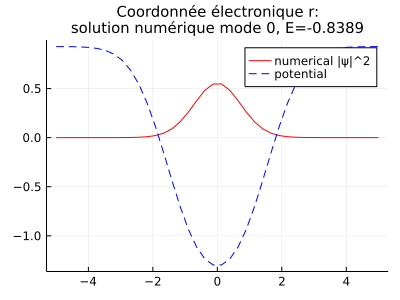

In [48]:
nb_modes_x = 5;
@time lE⁰x, lϕ⁰x, infos = KrylovKit.eigsolve(Ĥ⁰r, N, nb_modes_x, :SR, krylovdim=30);
@show infos.converged
nx = 0; densité_x = N/(r_max-r_min);
plot(rs,
    [densité_x*abs.(lϕ⁰x[nx+1]).^2, V₀r],
    grid=true,
    w=[1 1],
    color = ["red" "blue"],
    linestyle=[:solid :dash],
    label=["numerical |ψ|^2" "potential"],
    title = "Coordonnée électronique r:\nsolution numérique mode $nx, E=$(round(lE⁰x[nx+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

### 5) Calcul Axe $(Oy)$ des plus petits éléments propres (états + énergies) du hamiltonien nucléaire $H_R$

In [49]:
using Polynomials, SpecialPolynomials
x = variable(Polynomial{Rational{Int}})
H = [SpecialPolynomials.basis(Hermite, i)(x) for i in 0:20] # /!\ au décalage d'incice
ϕ1Dω = (n,x,m,ω,ħ) -> (m*ω/ħ)^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1](sqrt(m*ω/ħ)*x)*exp(-m*ω/2/ħ*x^2);
ϕ1Dk = (n,x,m,k,ħ) -> (k*m)^(.125)/ħ^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1]((k*m)^(.25)/sqrt(ħ)*x)*exp(-sqrt(k*m)/2/ħ*x^2);

  0.001364 seconds (1.14 k allocations: 227.344 KiB)
infos.converged = 6


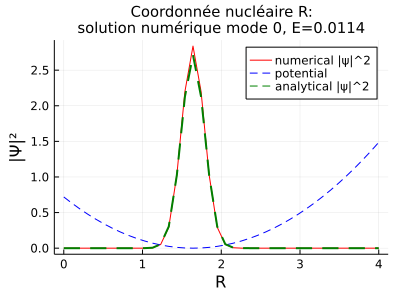

In [50]:
nb_modes_y = 5;
@time lE⁰y, lϕ⁰y, infos = KrylovKit.eigsolve(Ĥ⁰R, N, nb_modes_y, :SR, krylovdim=20);
@show infos.converged
ny = 0; densité_y = N/(R_max-R_min);
sol_analytique_y = [ϕ1Dk(ny,y-R₀,M,∂²RR_of_E₀_at_R₀,ħ) for y in Rs];
plot(Rs,
    [densité_y*abs.(lϕ⁰y[ny+1]).^2, V₀R, sol_analytique_y.^2],
    grid=true, w=[1 1 2],
    color = ["red" "blue" "green"],
    xlabel="R",ylabel="|Ψ|²",
    linestyle=[:solid :dash :dash],
    label=["numerical |ψ|^2" "potential" "analytical |ψ|^2"],
    title = "Coordonnée nucléaire R:\nsolution numérique mode $ny, E=$(round(lE⁰y[ny+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

### 6) Calcul de la solution-produit séparable du hamiltonien non perturbé $H_{HBO}$

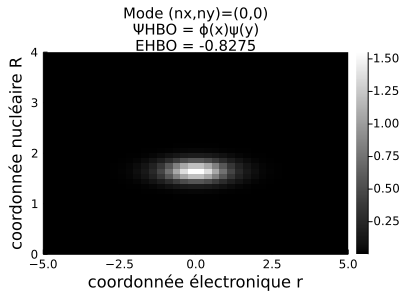

In [51]:
nxc = 0; nyc = 0;
ΨHBO_v = lϕ⁰x[nxc+1] * lϕ⁰y[nyc+1]'; # normé car les deux le sont
ΨHBO = reshape(ΨHBO_v,N*N)
EHBO = lE⁰x[nxc+1] + lE⁰y[nyc+1];
densité = N^2/(R_max-R_min)/(r_max-r_min);
heatmap(rs, Rs, densité*ΨHBO_v'.^2,
    color=:greys,
    aspect_ratio=:auto,
    xlim=[r_min,r_max], ylim=[R_min, R_max],
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    size=(400,300),
    titlefontsize=10,
    title = "Mode (nx,ny)=($nxc,$nyc)\nΨHBO = ϕ(x)ψ(y)\nEHBO = $(round(EHBO,digits=4))")

In [52]:
using IterativeSolvers
using LinearAlgebra
using CUDA
CUDA.reclaim()

Ψ₀ = cu(convert(Vector{Float32}, ΨHBO));
W = cu(convert(Matrix{Float32}, Ŵ));
H₀ = cu(convert(SparseMatrixCSC{Float32}, Ĥ⁰));



Π_par  = Ψ₀*Ψ₀';
Π_ort  = Diagonal(CUDA.ones(N*N)) - Π_par;
Qmax   = 5;

P_ort  = H₀*Π_ort; # produit sparse*dense fonctionne mais pas dans l'autre sens
P_ort  = Π_ort*P_ort - EHBO*Π_ort; # Π⟂(H₀-E₀)Π⟂
P_par  = H₀*Π_par;
P_par  = Π_par*P_par - EHBO*Π_par; # Π∥(H₀-E₀)Π∥

llΨ    = zeros(Float32, N*N, Qmax);
llE    = zeros(Float32, Qmax);

R_ort  = -Π_ort*W; 
b      = R_ort*Ψ₀;
b_acc  = zeros(Float32, N*N);
Ψ_acc1 = CUDA.zeros(N*N);
Ψ_acc2 = CUDA.zeros(N*N);

# GC ordre 1 et sauvegarde
Ψ_acc1[:] = cg(P_ort, b);
Ψ_acc2[:] = Ψ_acc1;
llΨ[:,1]  = Array(Ψ_acc1);
llE[1]    = Ψ₀'*W*Ψ₀;

R_par = -P_par*W + llE[1]*P_par;
R_ort +=           llE[1]*P_ort;



for q ∈ 2:Qmax
    for i ∈ 1:(q-1)
        llE[q] = llE[q] -1/2*dot(llΨ[i], llΨ[q-i]);
    end
    
    fill!(b_acc, 0);
    fill!(b,     0);
    for i ∈ 1:(q-2)
        b_acc[:] = @views b_acc + llE[q-i]*llΨ[:,i];
    end
    b[:] = cu(b_acc);
    b[:] = b + llE[q]*Ψ₀;
    Ψ_acc1[:] = cg(P_ort, Π_ort*b + R_ort*Ψ_acc1);
    Ψ_acc2[:] = cg(P_ort, Π_par*b + R_par*Ψ_acc2) + Ψ_acc1;
    llΨ[:,q] = Array(Ψ_acc2);
end

Ψ_sol = copy(ΨHBO);
for i in 1:Qmax
    Ψ_sol[:] = @views Ψ_sol + λ^i*llΨ[:,i]
end

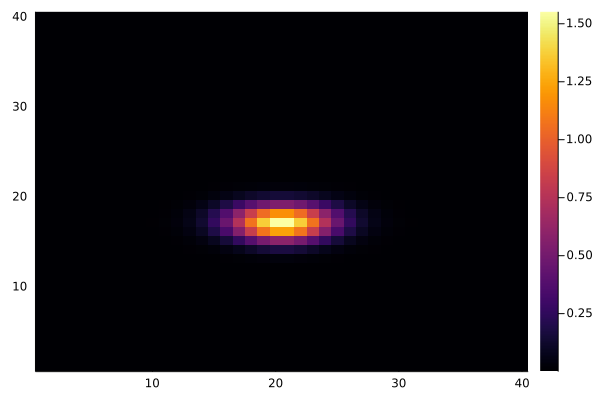

In [53]:
heatmap(densité*reshape(convert(Vector{Float64},Ψ_sol.^2),N,N)')

In [91]:
r = sprand(4,4,.2)
s = cu(convert(Matrix{Float32}, r))

4×4 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0       0.0       0.0
 0.0  0.0       0.0       0.0
 0.0  0.190787  0.0       0.0
 0.0  0.67993   0.985651  0.0

In [149]:
N_t = 1000
r = convert(Float32, 5.4)
s = CUDA.rand(N_t,N_t);
t = CUDA.CUSPARSE.CuSparseMatrixCSC(sprand(Float32,N_t,N_t,1/N_t))
CUDA.@time t*s; # s*t non
CUDA.@time s*s;

  0.008730 seconds (101 CPU allocations: 4.344 KiB) (1 GPU allocation: 3.815 MiB, 0.21% memmgmt time)
  0.010358 seconds (83 CPU allocations: 4.031 KiB) (1 GPU allocation: 3.815 MiB, 0.16% memmgmt time)


In [143]:
N_t = 3000;
v1 = rand(N_t)
v2 = rand(N_t)
@time v1'*v2
@time dot(v1,v2)

  0.004698 seconds (1.88 k allocations: 119.268 KiB, 92.78% compilation time)
  0.004208 seconds (16 allocations: 928 bytes, 99.57% compilation time)


749.4585632102888

In [43]:
using CUDA
a = CUDA.ones(5)
r = CUDA.rand(5,5)
t = zeros(5,5)
#r - Diagonal(a)
CUDA.@time t[:,1] = Array(r*a);

  0.001355 seconds (59 CPU allocations: 3.688 KiB) (1 GPU allocation: 20 bytes, 1.18% memmgmt time)


In [39]:
using CUDA
N = 5000
t = CUDA.rand(N);
CUDA.@time @views t[:] = CUDA.ones(N);

  0.001379 seconds (92 CPU allocations: 4.922 KiB) (1 GPU allocation: 19.531 KiB, 1.21% memmgmt time)


In [40]:
CUDA.@time t[:] = CUDA.ones(N);
t = nothing
CUDA.reclaim()

  0.001102 seconds (91 CPU allocations: 4.891 KiB) (1 GPU allocation: 19.531 KiB, 1.66% memmgmt time)


In [68]:
a = CUDA.rand(5,5)
b[:] = a
fill!(a,0)
b

5×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.129655   0.195801  0.961048   0.391877   0.879249
 0.0633536  0.198139  0.0132472  0.379528   0.1819
 0.173148   0.963232  0.493694   0.0165312  0.0623482
 0.53322    0.706055  0.596665   0.29366    0.830973
 0.862015   0.154294  0.284755   0.926223   0.597311

In [59]:
a = CUDA.ones(5)
r = CUDA.rand(5,5)
t = CUDA.rand(5)
s = CUDA.rand(5,5)
CUDA.@time d = a + s*t;
CUDA.@time cg(r,d)

  0.001198 seconds (86 CPU allocations: 5.328 KiB) (2 GPU allocations: 40 bytes, 1.44% memmgmt time)
  0.003298 seconds (731 CPU allocations: 46.703 KiB) (4 GPU allocations: 80 bytes, 0.57% memmgmt time)


5-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  1.7119342
  1.191223
  1.4654402
  5.1460648
 -0.35538095

In [63]:
CUDA.@time cg(r,a+s*t)

  0.003012 seconds (767 CPU allocations: 48.656 KiB) (6 GPU allocations: 120 bytes, 0.85% memmgmt time)


5-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  1.7119342
  1.191223
  1.4654402
  5.1460648
 -0.35538095

In [46]:
CUDA.@time fill!(r, 0)

  0.001406 seconds (53 CPU allocations: 3.438 KiB)


5×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [75]:
typeof(t)

CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}

In [32]:
HmEHBO = Ĥ⁰-Diagonal(EHBO*ones(N*N))
@show typeof(HmEHBO);
@show ishermitian(HmEHBO);
@show isposdef(HmEHBO)
@time F = factorize(HmEHBO);
vals, ~, infos = KrylovKit.eigsolve(HmEHBO, N*N, 1, :SR, krylovdim=20); # vérification si la plus petite valeur propre est bien nulle
@assert infos.converged >= 1
@show vals[1];
@show norm(Ĥ⁰*ΨHBO-EHBO*ΨHBO); # valeur propre (0) est bien majorée par la norme du résidu

typeof(HmEHBO) = SparseMatrixCSC{Float64, Int64}
ishermitian(HmEHBO) = true
isposdef(HmEHBO) = false
  0.001689 seconds (65 allocations: 1.353 MiB)
vals[1] = -2.062433948425952e-14
norm(Ĥ⁰ * ΨHBO - EHBO * ΨHBO) = 3.8457038344180585e-14


In [19]:
using CUDA
CUDA.reclaim()
Π = convert(Matrix{Float32}, ΨHBO*ΨHBO');
Π_gpu = cu(Π); # 6400×6400 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
HmEHBO = convert(SparseMatrixCSC{Float32}, Ĥ⁰-Diagonal(EHBO*ones(N*N))); 
HmEHBO_gpu = cu(HmEHBO); # 6400×6400 CUDA.CUSPARSE.CuSparseMatrixCSC{Float32, Int32} with 31680 stored entries:
CUDA.@time HmEHBO_gpu = HmEHBO_gpu*Π_gpu;
CUDA.@time HmEHBO_gpu = Π_gpu*HmEHBO_gpu;

In [ ]:
# construction des vecteurs sur GPU ensuite pour les calculs
using CUDA;
CUDA.device_reset!()
CUDA.reclaim()

# Π projecteur sur l'orthogonal de ΨHBO
Π = Matrix(I,N*N,N*N) - ΨHBO*ΨHBO';
Π_32       = convert(Matrix{Float32}, Π); # changer en double précision 64 bits des GPU équipés de cœors adaptés (cluster)
Π_gpu      = cu(Π_32);

# H - E0
HmEHBO = Ĥ⁰-Diagonal(EHBO*ones(N*N))
HmEHBO_32  = convert(SparseMatrixCSC{Float32}, HmEHBO); # idem
HmEHBO_gpu = cu(HmEHBO_32);

# Ŵ Perturbation
# ... W existe déjà
W_32 = convert(Matrix{Float32}, Ŵ);
W_gpu = cu(W_32);

# membre de droite
bcg = -Π*Ŵ*ΨHBO # toujours faire les produits en 64 bits avant de convertir en 32bits pour éviter la propagation d'erreurs
bcg_32 = convert(Array{Float32}, bcg);
bcg_gpu = cu(bcg_32);

# application linéaire sur laquelle résoudre
Acg = Π*HmEHBO*Π;
Acg_32 = convert(Matrix{Float32}, Acg);
Acg_gpu = cu(Acg_32);


# types 
@show typeof(Π_gpu);
@show typeof(HmEHBO_gpu);
@show typeof(W_gpu);
@show typeof(bcg_gpu);


In [51]:
N = 50*50;
A = rand(N,N);
t = rand(N);
s = rand(N);
# @time t'*A*s
@time dot(t, A, s);
using CUDA
A_gpu = cu(A);
t_gpu = cu(t);
s_gpu = cu(s);
CUDA.@time t_gpu'*A_gpu*s_gpu;

  0.004256 seconds (1 allocation: 16 bytes)
  0.003907 seconds (32 CPU allocations: 640 bytes) (1 GPU allocation: 9.766 KiB, 0.35% memmgmt time)


In [28]:
# gradients conjugués avec et sans gpu
using IterativeSolvers;

# ordre 1
CUDA.@time Ψ1_gpu = cg(Acg_gpu, bcg_gpu);
@time      Ψ1_32  = cg(Acg_32, bcg_32);
# @assert Ψ1_32 ≈ Vector(Ψ1_gpu);
E1 = (ΨHBO+λ*Ψ1_32)'*(Ĥ⁰+λ*Ŵ)*(ΨHBO+λ*Ψ1_32);

# ordre 2 (gpu uniquement)
# màj membre de droite
bcg_gpu = -Acg_gpu*Ψ1_gpu + E1*Ψ1_gpu # toujours faire les produits avant de convertir en 32bits au possible
CUDA.@time Ψ2_gpu = cg(Acg_gpu, bcg_gpu);

 29.374644 seconds (63.66 M CPU allocations: 3.321 GiB, 4.04% gc time) (4 GPU allocations: 39.062 KiB, 0.00% memmgmt time)
  0.456681 seconds (1.24 M allocations: 65.344 MiB, 85.83% compilation time)
 12.264701 seconds (35.44 M CPU allocations: 1.835 GiB, 4.80% gc time) (4 GPU allocations: 78.125 KiB, 0.00% memmgmt time)


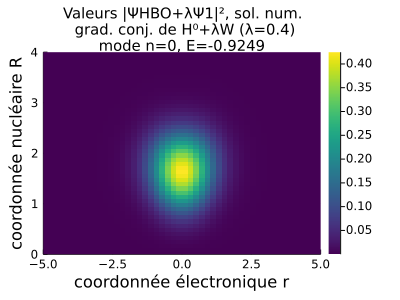

In [35]:
heatmap(rs,Rs, densité*transpose(reshape((ΨHBO+λ*Ψ1_32).^2,N,N)),
    xlims = (r_min,r_max),
    ylims = (R_min,R_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    color=:viridis,
    title = "Valeurs |ΨHBO+λΨ1|², sol. num.\n grad. conj. de H⁰+λW (λ=$λ)\nmode n=$mode_numérique, E=$(round(EHBO+λ*E1,digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    right_margin = 8Plots.mm,
    up_margin = 4Plots.mm)

In [38]:
norm(ϕHλW-ΨHBO-λ*Ψ1_32)/densité

0.00015210217611464927

### Brouillon

In [ ]:
using IterativeSolvers;

Π_orth = Matrix(I,N*N,N*N) - ΨHBO*ΨHBO'; # projecteur sur l'orthogonal de ΨHBO /!\ fonctionne car ΨHBO est normé
ΠHmEHBOΠ = Π*HmEHBO*Π;
## ORDRE 1
bcg = -Π*Ŵ*ΨHBO;
Ψ1 = cg(ΠHmEHBOΠ, bcg);
E1 = ΨHBO'*Ŵ*ΨHBO;

## ORDRE 2
bcg = -ΠHmEHBOΠ*Ψ1 + E1*Ψ1;
Ψ2 = cg(ΠHmEHBOΠ, bcg)



d = rand(10);
d = d/norm(d);
Π_span = d*d';
Π_orth = Matrix(I,10,10) - d*d';
r = rand(10);
r_orth = Π_orth*r;
r_span = Π_span*r;
r ≈ r_orth + r_span;
r_orth'*r_span # vérifier qu'ils sont orthogonaux
@show Π_span ≈ Π_span*Π_span
@show Π_orth ≈ Π_orth*Π_orth